<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 1 is a jupyter notebook showing an example image(s) of a satellite dataset read in using rasterio, and demonstration of a function that carries out a manipulation of that image using keras and Tensorflow 2.0. That manipulation could be anything that alters the image, such as its size, geometry (shape), pixel intensities, or spatial projection. This will mostly test your understanding of keras syntax, which is an essential component of the remaining Parts. You may find the <a href="https://www.tensorflow.org/api_docs/python/tf/image">tensorflow-image</a> library helpful.
    </p>

## Step 1: Download sattelite image from sentinal-2 cloudless


The following code downloads data from the [sentinal-2 cloudless](https://s2maps.eu/) image service download tool and is adopted from the part 2 liveproject notebook.

In [1]:
import urllib.request

In [2]:
root = "https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1&"
layers = 'layers=s2cloudless-2018&'
bbox = 'bbox=-116.21928854749297,32.903320741965295,-115.40080710218047,33.724548769309045&'
width = 'width=4096&'
height = 'height=4096&'
srs = 'srs=epsg:4326'

#construct and print the url
url = root+layers+bbox+width+height+srs
print(url)

https://tiles.maps.eox.at/wms?service=wms&request=getmap&version=1.1.1&layers=s2cloudless-2018&bbox=-116.21928854749297,32.903320741965295,-115.40080710218047,33.724548769309045&width=4096&height=4096&srs=epsg:4326


In [3]:
def download_all_layers(root,layers,bbox,width,height,srs,site):
    #cycle through each layer to download
    for layer in layers:
        # construct a URL string 
        url = root+layer+bbox+width+height+srs
        #download into a filename constructed as "site_layer.jpg"
        urllib.request.urlretrieve(url, site+'_'+layer.split('=')[-1].split('&')[0]+'.jpg')
        


In [4]:
# define the output
#Salton Sea, USA 
bbox = 'bbox=-116.21928854749297,32.903320741965295,-115.40080710218047,33.724548769309045&'
layers = ['layers=s2cloudless&','layers=s2cloudless-2018&']
download_all_layers(root,layers,bbox,width,height,srs,'salton_sea')

## Step 2: Reading Image with Rasterio

In [5]:
import rasterio 
import os

In [6]:
os.getcwd()

'/home/ec2-user/SageMaker/LP_satellite_imagery'

In [7]:
with rasterio.open(os.path.join('salton_sea_s2cloudless.jpg'),driver='JPEG') as image:
    image_array = image.read(1)
    print(image.profile)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'driver': 'JPEG', 'dtype': 'uint8', 'nodata': None, 'width': 4096, 'height': 4096, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'compress': 'jpeg', 'interleave': 'pixel', 'photometric': 'ycbcr'}


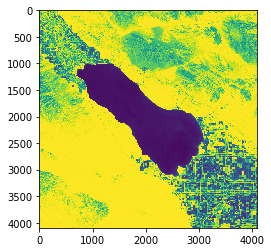

In [8]:
from matplotlib import pyplot as plt

plt.imshow(image_array)

Its clear this is not a natural color satellite image. From the [documentation](https://rasterio.readthedocs.io/en/latest/topics/image_processing.html), it is noted that rasterio represents image data differently than other image processing packages such as pyplot. We'll show the image with rasterio's  plot.show() function and then convert the image so it can be used by matplotlib / tensorflow.

In [9]:
from rasterio.plot import show

In [10]:
src = rasterio.open(os.path.join('salton_sea_s2cloudless.jpg'),driver='JPEG')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


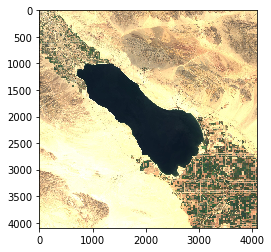

In [11]:
show(src)

The DatasetReader object stores the R-G-B bands in arrays indexed at 1, 2, and 3 respectively. These single-band images are displayed below with their corresponding colormap.

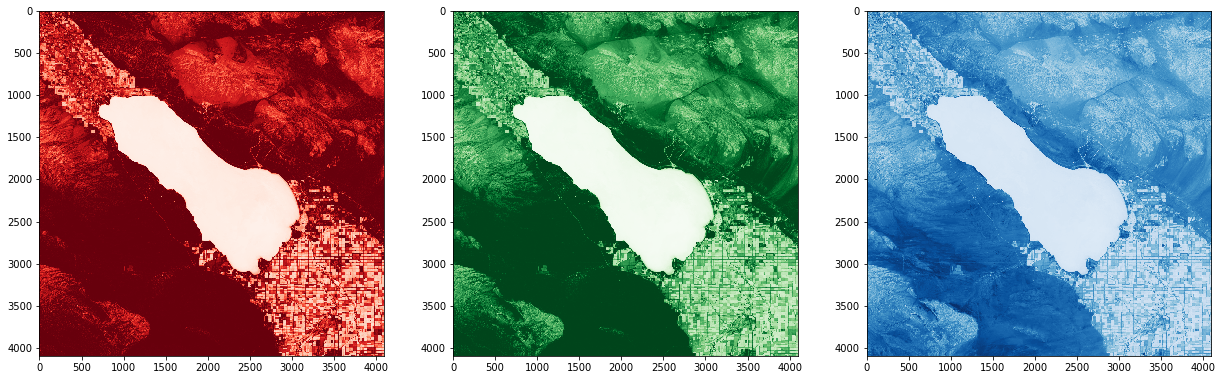

In [12]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
bands = ['Reds','Greens','Blues']

for band in range(1,4):
    show((src,band), ax=axes[band-1], cmap=bands[band-1])

In [13]:
from rasterio.plot import reshape_as_raster, reshape_as_image

In [14]:
# reshape raster file to image
src_image = reshape_as_image(src.read())

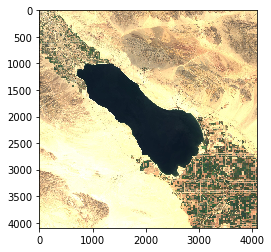

In [15]:
plt.imshow(src_image)

We can see this matches the natural color version of the image as interpreted by rasterio.

## Step 3 (Deliverable): Image Manipulation in Keras / Tensorflow

In [16]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.1.0'

#### Convert to grayscale

In [17]:
#first, convert to grayscale 

grayscale_tensor = tf.image.rgb_to_grayscale(src_image)
grayscale_img = np.array(grayscale_tensor)

In [18]:
src.read().shape

(3, 4096, 4096)

In [19]:
grayscale_img.shape

(4096, 4096, 1)

This demonstrates that the 3 channels initially read into the image file have been condensed into one channel (grayscale). We'll show the resulting output with the gray colormap using both rasterio and pyplot, since they require different minor manipulation to display the image. Rasterio requires the array be rearranged to raster format, and pyplot imshow requires that the grayscale image is squeezed.

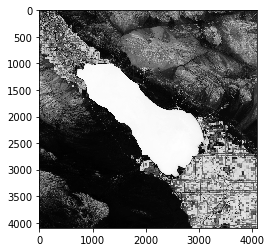

In [20]:
show(reshape_as_raster(grayscale_img), cmap='Greys')

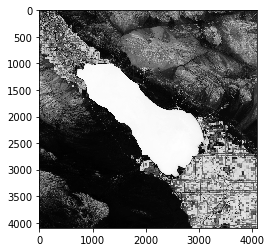

In [21]:
plt.imshow(grayscale_img.squeeze(),cmap='Greys')

#### Rotate

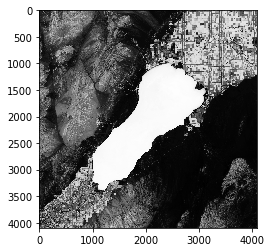

In [22]:
grayscale_rot = np.array(tf.image.rot90(grayscale_img))
show(reshape_as_raster(grayscale_rot),cmap='Greys')

#### Transpose

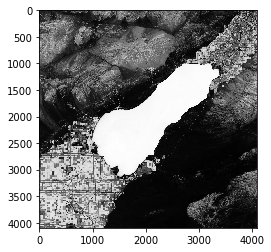

In [23]:
show(reshape_as_raster(np.array(tf.image.transpose(grayscale_rot))),cmap='Greys')

#### Resize with pad

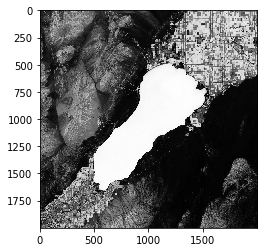

In [24]:
show(reshape_as_raster(np.array(tf.image.resize_with_pad(grayscale_rot,2000,2000))),cmap='Greys')

In [25]:
### close the datasource
src.close()